# Autoscout Car Prediction

# Libraries

In [160]:
import pandas as pd
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
pd.options.display.float_format = '{:.3f}'.format

# User Defined Functions

In [4]:
def adj_r2(actual, prediction, X):
    r2 = r2_score(actual, prediction)
    n = X.shape[0]   
    p = X.shape[1]   
    adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
    return adj_r2

def train_val(model, X_train, y_train, X_test, y_test, title):
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    scores = {
       title + "_train": {"R2" : r2_score(y_train, y_train_pred),
                           "mae" : mean_absolute_error(y_train, y_train_pred),
                           "mse" : mean_squared_error(y_train, y_train_pred),
                           "rmse" : mean_squared_error(y_train, y_train_pred, squared=False),
                           #"rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred)),
                           "mape": mean_absolute_percentage_error(y_train, y_train_pred),
                           "Adjust R2": adj_r2(y_train, y_train_pred, X_train) },
        
       title + "_test": {"R2" : r2_score(y_test, y_pred),
                          "mae" : mean_absolute_error(y_test, y_pred),
                          "mse" : mean_squared_error(y_test, y_pred),
                          "rmse" : mean_squared_error(y_test, y_pred, squared=False),                          
                          "mape": mean_absolute_percentage_error(y_test, y_pred),
                          "Adjust R2": adj_r2(y_test, y_pred, X_test)}}
    
    return pd.DataFrame(scores)

In [5]:
df = pd.read_csv("final_scout_not_dummy.csv")
df.head()

,make_model,body_type,price,vat,km,Type,Fuel,Gears,Comfort_Convenience,Entertainment_Media,...,Previous_Owners,hp_kW,Inspection_new,Paint_Type,Upholstery_type,Gearing_Type,Displacement_cc,Weight_kg,Drive_chain,cons_comb
0,Audi A1,Sedans,15770,VAT deductible,56013.000,Used,Diesel,7.000,"Air conditioning,Armrest,Automatic climate con...","Bluetooth,Hands-free equipment,On-board comput...",...,2.000,66.000,1,Metallic,Cloth,Automatic,1422.000,1220.000,front,3.800
1,Audi A1,Sedans,14500,Price negotiable,80000.000,Used,Benzine,7.000,"Air conditioning,Automatic climate control,Hil...","Bluetooth,Hands-free equipment,On-board comput...",...,1.000,141.000,0,Metallic,Cloth,Automatic,1798.000,1255.000,front,5.600
2,Audi A1,Sedans,14640,VAT deductible,83450.000,Used,Diesel,7.000,"Air conditioning,Cruise control,Electrical sid...","MP3,On-board computer",...,1.000,85.000,0,Metallic,Cloth,Automatic,1598.000,1135.000,front,3.800
3,Audi A1,Sedans,14500,VAT deductible,73000.000,Used,Diesel,6.000,"Air suspension,Armrest,Auxiliary heating,Elect...","Bluetooth,CD player,Hands-free equipment,MP3,O...",...,1.000,66.000,0,Metallic,Cloth,Automatic,1422.000,1195.000,front,3.800
4,Audi A1,Sedans,16790,VAT deductible,16200.000,Used,Diesel,7.000,"Air conditioning,Armrest,Automatic climate con...","Bluetooth,CD player,Hands-free equipment,MP3,O...",...,1.000,66.000,1,Metallic,Cloth,Automatic,1422.000,1135.000,front,4.100


# EDA

In [6]:
df.columns

Index(['make_model', 'body_type', 'price', 'vat', 'km', 'Type', 'Fuel',
       'Gears', 'Comfort_Convenience', 'Entertainment_Media', 'Extras',
       'Safety_Security', 'age', 'Previous_Owners', 'hp_kW', 'Inspection_new',
       'Paint_Type', 'Upholstery_type', 'Gearing_Type', 'Displacement_cc',
       'Weight_kg', 'Drive_chain', 'cons_comb'],
      dtype='object')

In [7]:
df.select_dtypes(include=['number']).corr()

,price,km,Gears,age,Previous_Owners,hp_kW,Inspection_new,Displacement_cc,Weight_kg,cons_comb
price,1.000,-0.399,0.530,-0.473,-0.145,0.696,0.008,0.282,0.468,0.272
km,-0.399,1.000,-0.033,0.758,0.157,0.004,-0.049,0.307,0.147,-0.300
Gears,0.530,-0.033,1.000,-0.065,-0.037,0.450,-0.011,0.340,0.334,-0.004
age,-0.473,0.758,-0.065,1.000,0.316,-0.083,-0.046,0.215,0.065,-0.341
Previous_Owners,-0.145,0.157,-0.037,0.316,1.000,-0.023,0.020,0.028,0.003,-0.020
hp_kW,0.696,0.004,0.450,-0.083,-0.023,1.000,0.037,0.597,0.638,0.389
Inspection_new,0.008,-0.049,-0.011,-0.046,0.020,0.037,1.000,-0.026,-0.036,0.148
Displacement_cc,0.282,0.307,0.340,0.215,0.028,0.597,-0.026,1.000,0.563,0.038
Weight_kg,0.468,0.147,0.334,0.065,0.003,0.638,-0.036,0.563,1.000,0.089
cons_comb,0.272,-0.300,-0.004,-0.341,-0.020,0.389,0.148,0.038,0.089,1.000


In [8]:
correlations = df.drop("price", axis=1).corrwith(df["price"],numeric_only = True).to_frame(name="Correlation with Price")
filtered_correlations = correlations[
    ((correlations > 0.3) | (correlations < -0.3)) & (correlations.notnull()) & (correlations != 1)
]

filtered_correlations = filtered_correlations.applymap(lambda x: np.nan if np.isnan(x) else x)
sorted_correlations = filtered_correlations.dropna().sort_values(by="Correlation with Price", ascending=False)
sorted_correlations

,Correlation with Price
hp_kW,0.696
Gears,0.530
Weight_kg,0.468
km,-0.399
age,-0.473


In [9]:
df.select_dtypes(include=['object']).columns.tolist()

['make_model',
 'body_type',
 'vat',
 'Type',
 'Fuel',
 'Comfort_Convenience',
 'Entertainment_Media',
 'Extras',
 'Safety_Security',
 'Paint_Type',
 'Upholstery_type',
 'Gearing_Type',
 'Drive_chain']

In [10]:
df["make_model"].value_counts()

make_model
Audi A3           3097
Audi A1           2614
Opel Insignia     2598
Opel Astra        2525
Opel Corsa        2216
Renault Clio      1839
Renault Espace     991
Renault Duster      34
Audi A2              1
Name: count, dtype: int64

In [11]:
df["Type"].value_counts()

Type
Used              11095
New                1649
Pre-registered     1364
Employee's car     1011
Demonstration       796
Name: count, dtype: int64

In [12]:
df["Upholstery_type"].value_counts()

Upholstery_type
Cloth                12234
Part/Full Leather     3681
Name: count, dtype: int64

In [13]:
df["Gearing_Type"].value_counts()

Gearing_Type
Manual            8149
Automatic         7297
Semi-automatic     469
Name: count, dtype: int64

In [14]:
df.describe()

,price,km,Gears,age,Previous_Owners,hp_kW,Inspection_new,Displacement_cc,Weight_kg,cons_comb
count,15915.000,15915.000,15915.000,15915.000,15915.000,15915.000,15915.000,15915.000,15915.000,15915.000
mean,18024.381,32089.996,5.937,1.390,1.043,88.499,0.247,1428.662,1337.701,4.832
std,7381.679,36977.215,0.705,1.121,0.339,26.674,0.431,275.804,199.682,0.868
min,4950.000,0.000,5.000,0.000,0.000,40.000,0.000,890.000,840.000,3.000
25%,12850.000,1920.500,5.000,0.000,1.000,66.000,0.000,1229.000,1165.000,4.100
50%,16900.000,20413.000,6.000,1.000,1.000,85.000,0.000,1461.000,1295.000,4.800
75%,21900.000,46900.000,6.000,2.000,1.000,103.000,0.000,1598.000,1472.000,5.400
max,74600.000,317000.000,8.000,3.000,4.000,294.000,1.000,2967.000,2471.000,9.100


In [15]:
X = df[["make_model", "Gearing_Type", "Gears", "age", "km", "hp_kW", "Weight_kg", "Type", "Upholstery_type"]]
y = df["price"]

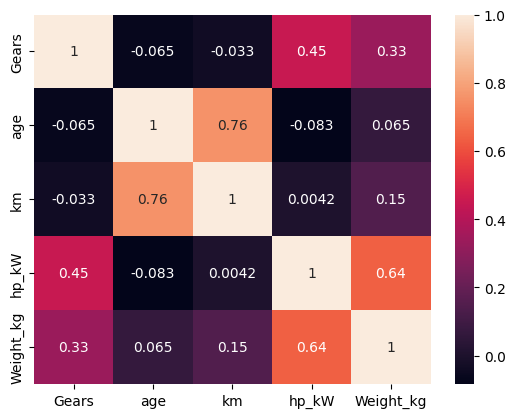

In [16]:
df_numeric = X.select_dtypes(include ="number")
sns.heatmap(df_numeric.corr(), annot =True);

In [17]:
df_numeric.corr()[(abs(df_numeric.corr())>= 0.9) & (abs(df_numeric.corr()) < 1)].any()

Gears        False
age          False
km           False
hp_kW        False
Weight_kg    False
dtype: bool

In [18]:
df_numeric.corr()[(abs(df_numeric.corr())>= 0.9) & (abs(df_numeric.corr()) < 1)].any().any()

False

In [19]:
df_vif = pd.DataFrame()
df_vif['features'] = df_numeric.columns
df_vif["VIF"] = [variance_inflation_factor(df_numeric.values, i) for i in range(len(df_numeric.columns))]
df_vif

,features,VIF
0,Gears,43.119
1,age,5.984
2,km,4.195
3,hp_kW,20.555
4,Weight_kg,58.905


# Data Preparation

In [20]:
df1 = df[["make_model", "Gearing_Type", "age", "km", "Type", "Upholstery_type", "price"]]
X = df1.drop(columns = ["price"])
y = df1.price

In [21]:
X.shape

(15915, 6)

In [22]:
X.head()

,make_model,Gearing_Type,age,km,Type,Upholstery_type
0,Audi A1,Automatic,3.000,56013.000,Used,Cloth
1,Audi A1,Automatic,2.000,80000.000,Used,Cloth
2,Audi A1,Automatic,3.000,83450.000,Used,Cloth
3,Audi A1,Automatic,3.000,73000.000,Used,Cloth
4,Audi A1,Automatic,3.000,16200.000,Used,Cloth


In [23]:
y.head()

0    15770
1    14500
2    14640
3    14500
4    16790
Name: price, dtype: int64

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
X_train.shape, X_test.shape

((12732, 6), (3183, 6))

In [26]:
cat = X_train.select_dtypes("object").columns
cat

Index(['make_model', 'Gearing_Type', 'Type', 'Upholstery_type'], dtype='object')

In [27]:
cat_onehot = ["make_model", "Gearing_Type", "Upholstery_type"]
cat_ordinal = ["Type"]
cat_for_type = ["Used", "Employee's car", "Demonstration", "Pre-registered", "New"]

In [28]:
enc_onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
enc_ordinal = OrdinalEncoder(categories= [cat_for_type,])
column_trans = make_column_transformer((enc_onehot, cat_onehot), 
                                       (enc_ordinal, cat_ordinal),
                                        remainder='passthrough',
                                        verbose_feature_names_out=False) 

In [29]:
X_train.head()

,make_model,Gearing_Type,age,km,Type,Upholstery_type
14306,Renault Clio,Manual,0.000,6332.000,Used,Cloth
2582,Audi A1,Manual,0.000,500.000,Pre-registered,Cloth
6302,Opel Astra,Manual,3.000,72000.000,Used,Cloth
9156,Opel Corsa,Manual,2.000,49000.000,Used,Cloth
15663,Renault Espace,Automatic,1.000,100.000,Pre-registered,Part/Full Leather


In [30]:
X_test.head()

,make_model,Gearing_Type,age,km,Type,Upholstery_type
12887,Opel Insignia,Manual,0.000,5900.000,Demonstration,Cloth
8140,Opel Astra,Manual,0.000,133.000,Demonstration,Cloth
6835,Opel Astra,Manual,2.000,8000.000,Used,Cloth
15439,Renault Espace,Automatic,0.000,15.000,Pre-registered,Part/Full Leather
1213,Audi A1,Manual,2.000,11903.000,Used,Cloth


# Linear Regression

In [31]:
operations_lr = [("OneHot_Ordinal_Encoder", column_trans), 
              #("scaler", MinMaxScaler()), 
              ("LinearRegression", LinearRegression())]

linear_regression_pipe = Pipeline(steps=operations_lr)

linear_regression_pipe.fit(X_train, y_train)

Pipeline(steps=[('OneHot_Ordinal_Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['make_model', 'Gearing_Type',
                                                   'Upholstery_type']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Used',
                                                                              "Employee's "
                                                                              'car',
                                                                              'Demonstration',
                                                                              'Pre-registered',
                                                                              'New']]),
                                                  ['Type'])],
                                   verbose_feature_names_out=False)),
                ('LinearRegression', LinearRegression())])

In [32]:
lr = train_val(linear_regression_pipe, X_train, y_train, X_test, y_test, "Linear Regression")
lr

,Linear Regression_train,Linear Regression_test
R2,0.801,0.809
mae,2172.319,2142.347
mse,10845167.110,10326934.357
rmse,3293.200,3213.555
mape,0.131,0.130
Adjust R2,0.801,0.808


## Linear Regreesion Cross Validation

In [33]:
linear_regression_cv = Pipeline(steps=operations_lr)

scores_lr = cross_validate(linear_regression_cv,
                          X_train, 
                          y_train,
                          scoring=['r2', 
                                   'neg_mean_absolute_error',
                                   'neg_mean_squared_error',
                                   'neg_root_mean_squared_error',
                                   'neg_mean_absolute_percentage_error'], 
                          cv=10, 
                          return_train_score=True)
pd.DataFrame(scores_lr).iloc[:, 2:].mean()

test_r2                                            0.801
train_r2                                           0.801
test_neg_mean_absolute_error                   -2175.391
train_neg_mean_absolute_error                  -2172.224
test_neg_mean_squared_error                -10877758.400
train_neg_mean_squared_error               -10843456.479
test_neg_root_mean_squared_error               -3291.716
train_neg_root_mean_squared_error              -3292.861
test_neg_mean_absolute_percentage_error           -0.131
train_neg_mean_absolute_percentage_error          -0.131
dtype: float64

In [34]:
pickle.dump(linear_regression_pipe, open("linear_regression", 'wb'))

# Ridge Regression 

In [35]:
scaler = MinMaxScaler().set_output(transform="pandas")

In [36]:
operations_rr = [("OneHot_Ordinal_Encoder", column_trans), 
                 ("scaler", MinMaxScaler()), 
                 ("Ridge", Ridge())]

ridge_regression_pipe= Pipeline(steps=operations_rr).set_output(transform="pandas")

ridge_regression_pipe.fit(X_train, y_train)

Pipeline(steps=[('OneHot_Ordinal_Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['make_model', 'Gearing_Type',
                                                   'Upholstery_type']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Used',
                                                                              "Employee's "
                                                                              'car',
                                                                              'Demonstration',
                                                                              'Pre-registered',
                                                                              'New']]),
                                                  ['Type'])],
                                   verbose_feature_names_out=False)),
                ('scaler', MinMaxScaler()), ('Ridge', Ridge())])

In [37]:
train_val(ridge_regression_pipe, X_train, y_train, X_test, y_test, "Ridge")

,Ridge_train,Ridge_test
R2,0.801,0.809
mae,2171.597,2141.409
mse,10845432.288,10324400.661
rmse,3293.240,3213.161
mape,0.131,0.130
Adjust R2,0.801,0.808


## Ridge Cross Validation

In [38]:
ridge_regression_cv = Pipeline(steps=operations_rr)

scores_rr = cross_validate(ridge_regression_cv,
                           X_train, 
                           y_train,
                           scoring=['r2', 
                                    'neg_mean_absolute_error',
                                   'neg_mean_squared_error',
                                   'neg_root_mean_squared_error',
                                   'neg_mean_absolute_percentage_error'], 
                           cv=10, 
                           return_train_score=True)
pd.DataFrame(scores_rr).iloc[:, 2:].mean()

test_r2                                            0.801
train_r2                                           0.801
test_neg_mean_absolute_error                   -2174.565
train_neg_mean_absolute_error                  -2171.421
test_neg_mean_squared_error                -10878144.881
train_neg_mean_squared_error               -10843779.401
test_neg_root_mean_squared_error               -3291.770
train_neg_root_mean_squared_error              -3292.910
test_neg_mean_absolute_percentage_error           -0.131
train_neg_mean_absolute_percentage_error          -0.131
dtype: float64

## Ridge Grid Search

In [39]:
alpha_space = [0.001, 0.01, 0.1, 10, 100]

In [40]:
rr_model = Pipeline(steps=operations_rr)

param_grid_rr = {'Ridge__alpha':alpha_space}

ridge_regression_grid_model = GridSearchCV(estimator=rr_model,
                                           param_grid=param_grid_rr,
                                           scoring='neg_root_mean_squared_error',
                                           cv=10,
                                           n_jobs = -1,
                                           return_train_score=True)

In [41]:
ridge_regression_grid_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('OneHot_Ordinal_Encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['make_model',
                                                                          'Gearing_Type',
                                                                          'Upholstery_type']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['Used',
                                                                                                     "Employee's "
                                                                                                     'car',
                                                                                                     'Demonstration',
                                                                                                     'Pre-registered',
                                                                                                     'New']]),
                                                                         ['Type'])],
                                                          verbose_feature_names_out=False)),
                                       ('scaler', MinMaxScaler()),
                                       ('Ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'Ridge__alpha': [0.001, 0.01, 0.1, 10, 100]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [42]:
ridge_regression_grid_model.best_params_

{'Ridge__alpha': 0.001}

In [43]:
#scaler = MinMaxScaler().set_output(transform="pandas")
operations_rr = [("OneHot_Ordinal_Encoder", column_trans), 
                ("scaler", MinMaxScaler()), 
                ("Ridge", Ridge(alpha = 0.001))]

ridge_regression = Pipeline(steps=operations_rr).set_output(transform="pandas")

ridge_regression.fit(X_train, y_train)

Pipeline(steps=[('OneHot_Ordinal_Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['make_model', 'Gearing_Type',
                                                   'Upholstery_type']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Used',
                                                                              "Employee's "
                                                                              'car',
                                                                              'Demonstration',
                                                                              'Pre-registered',
                                                                              'New']]),
                                                  ['Type'])],
                                   verbose_feature_names_out=False)),
                ('scaler', MinMaxScaler()), ('Ridge', Ridge(alpha=0.001))])

In [44]:
rr = train_val(ridge_regression, X_train, y_train, X_test, y_test, "Ridge")
rr

,Ridge_train,Ridge_test
R2,0.801,0.809
mae,2172.318,2142.346
mse,10845167.110,10326931.425
rmse,3293.200,3213.554
mape,0.131,0.130
Adjust R2,0.801,0.808


In [45]:
pickle.dump(ridge_regression, open("ridge_regression", 'wb'))

# Lasso Regression

In [46]:
operations_l = [("OneHot_Ordinal_Encoder", column_trans), 
                 ("scaler", MinMaxScaler()), 
                 ("Lasso", Lasso())]

lasso_regression_pipe = Pipeline(steps=operations_l)

lasso_regression_pipe.fit(X_train, y_train)

Pipeline(steps=[('OneHot_Ordinal_Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['make_model', 'Gearing_Type',
                                                   'Upholstery_type']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Used',
                                                                              "Employee's "
                                                                              'car',
                                                                              'Demonstration',
                                                                              'Pre-registered',
                                                                              'New']]),
                                                  ['Type'])],
                                   verbose_feature_names_out=False)),
                ('scaler', MinMaxScaler()), ('Lasso', Lasso())])

In [47]:
train_val(lasso_regression_pipe, X_train, y_train, X_test, y_test, "Lasso")

,Lasso_train,Lasso_test
R2,0.801,0.809
mae,2170.767,2140.391
mse,10845890.616,10321340.555
rmse,3293.310,3212.684
mape,0.131,0.130
Adjust R2,0.801,0.808


## Lasso Cross Validation

In [48]:
lasso_regression_pipe_cv = Pipeline(steps=operations_l)
scores_l = cross_validate(lasso_regression_pipe_cv, 
                          X_train, 
                          y_train,
                          scoring=['r2', 
                                   'neg_mean_absolute_error',
                                   'neg_mean_squared_error',
                                   'neg_root_mean_squared_error',
                                   'neg_mean_absolute_percentage_error'],
                          cv=10, 
                          return_train_score=True)
pd.DataFrame(scores_l).iloc[:, 2:].mean()

test_r2                                            0.801
train_r2                                           0.801
test_neg_mean_absolute_error                   -2173.854
train_neg_mean_absolute_error                  -2170.667
test_neg_mean_squared_error                -10878649.600
train_neg_mean_squared_error               -10844179.510
test_neg_root_mean_squared_error               -3291.835
train_neg_root_mean_squared_error              -3292.970
test_neg_mean_absolute_percentage_error           -0.131
train_neg_mean_absolute_percentage_error          -0.131
dtype: float64

## Lasso Grid Search

In [49]:
lr_model = Pipeline(steps=operations_l)

param_grid_l = {'Lasso__alpha':alpha_space}

lasso_regression_grid_model = GridSearchCV(estimator=lr_model,
                                           param_grid=param_grid_l,
                                           scoring='neg_root_mean_squared_error',
                                           cv=10,
                                           n_jobs = -1,
                                           return_train_score=True)

In [50]:
lasso_regression_grid_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('OneHot_Ordinal_Encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['make_model',
                                                                          'Gearing_Type',
                                                                          'Upholstery_type']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['Used',
                                                                                                     "Employee's "
                                                                                                     'car',
                                                                                                     'Demonstration',
                                                                                                     'Pre-registered',
                                                                                                     'New']]),
                                                                         ['Type'])],
                                                          verbose_feature_names_out=False)),
                                       ('scaler', MinMaxScaler()),
                                       ('Lasso', Lasso())]),
             n_jobs=-1,
             param_grid={'Lasso__alpha': [0.001, 0.01, 0.1, 10, 100]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [51]:
lasso_regression_grid_model.best_params_

{'Lasso__alpha': 0.001}

In [52]:
operations_l = [("OneHot_Ordinal_Encoder", column_trans), 
                ("scaler", MinMaxScaler()), 
                ("Lasso", Lasso(alpha = 0.001))]

lasso_regression = Pipeline(steps=operations_l).set_output(transform="pandas")

lasso_regression.fit(X_train, y_train)

Pipeline(steps=[('OneHot_Ordinal_Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['make_model', 'Gearing_Type',
                                                   'Upholstery_type']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Used',
                                                                              "Employee's "
                                                                              'car',
                                                                              'Demonstration',
                                                                              'Pre-registered',
                                                                              'New']]),
                                                  ['Type'])],
                                   verbose_feature_names_out=False)),
                ('scaler', MinMaxScaler()), ('Lasso', Lasso(alpha=0.001))])

In [53]:
l = train_val(lasso_regression, X_train, y_train, X_test, y_test, "Lasso")
l

,Lasso_train,Lasso_test
R2,0.801,0.809
mae,2172.317,2142.204
mse,10845167.110,10323643.358
rmse,3293.200,3213.043
mape,0.131,0.130
Adjust R2,0.801,0.808


In [54]:
pickle.dump(lasso_regression, open("lasso_regression", 'wb'))

# ElasticNet Regression

In [55]:
operations_er = [("OneHot_Ordinal_Encoder", column_trans), 
                 ("scaler", MinMaxScaler()), 
                 ("ElasticNet", ElasticNet())]

elastic_regression_pipe = Pipeline(steps=operations_er)

elastic_regression_pipe.fit(X_train, y_train)

Pipeline(steps=[('OneHot_Ordinal_Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['make_model', 'Gearing_Type',
                                                   'Upholstery_type']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Used',
                                                                              "Employee's "
                                                                              'car',
                                                                              'Demonstration',
                                                                              'Pre-registered',
                                                                              'New']]),
                                                  ['Type'])],
                                   verbose_feature_names_out=False)),
                ('scaler', MinMaxScaler()), ('ElasticNet', ElasticNet())])

In [56]:
train_val(elastic_regression_pipe, X_train, y_train, X_test, y_test, "ElasticNet")

,ElasticNet_train,ElasticNet_test
R2,0.419,0.431
mae,4144.022,4154.936
mse,31736375.990,30722699.915
rmse,5633.505,5542.806
mape,0.264,0.269
Adjust R2,0.419,0.430


## ElasticNet Cross Validation

In [57]:
elastic_regression_pipe_cv = Pipeline(steps=operations_er)
scores_er = cross_validate(elastic_regression_pipe_cv,
                           X_train, 
                           y_train,
                           scoring=['r2', 
                                   'neg_mean_absolute_error',
                                   'neg_mean_squared_error',
                                   'neg_root_mean_squared_error',
                                   'neg_mean_absolute_percentage_error'],
                           cv=10, 
                           return_train_score=True)
pd.DataFrame(scores_er).iloc[:, 2:].mean()

test_r2                                            0.419
train_r2                                           0.419
test_neg_mean_absolute_error                   -4145.196
train_neg_mean_absolute_error                  -4143.657
test_neg_mean_squared_error                -31758159.526
train_neg_mean_squared_error               -31731298.188
test_neg_root_mean_squared_error               -5630.089
train_neg_root_mean_squared_error              -5633.015
test_neg_mean_absolute_percentage_error           -0.264
train_neg_mean_absolute_percentage_error          -0.264
dtype: float64

## ElasticNet Grid Search

In [58]:
er_model = Pipeline(steps=operations_er)

param_grid_er = {'ElasticNet__alpha':[0.001,0.01, 0.5, 1, 2,  3, 4],
                 'ElasticNet__l1_ratio':[.5, .7, .9, .95, .99, 1]}

elastic_regression_grid_model = GridSearchCV(estimator=er_model,
                                             param_grid=param_grid_er,
                                             scoring='neg_root_mean_squared_error', 
                                             cv=10,
                                             n_jobs = -1,
                                             return_train_score=True)

In [59]:
elastic_regression_grid_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('OneHot_Ordinal_Encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['make_model',
                                                                          'Gearing_Type',
                                                                          'Upholstery_type']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['Used',
                                                                                                     "Employee's "
                                                                                                     'car',
                                                                                                     'Demonstration',
                                                                                                     'Pre-registered',
                                                                                                     'New']]),
                                                                         ['Type'])],
                                                          verbose_feature_names_out=False)),
                                       ('scaler', MinMaxScaler()),
                                       ('ElasticNet', ElasticNet())]),
             n_jobs=-1,
             param_grid={'ElasticNet__alpha': [0.001, 0.01, 0.5, 1, 2, 3, 4],
                         'ElasticNet__l1_ratio': [0.5, 0.7, 0.9, 0.95, 0.99,
                                                  1]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [60]:
elastic_regression_grid_model.best_params_

{'ElasticNet__alpha': 0.001, 'ElasticNet__l1_ratio': 1}

In [61]:
operations_er = [("OneHot_Ordinal_Encoder", column_trans), 
                 ("scaler", MinMaxScaler()), 
                 ("ElasticNet", ElasticNet(alpha = 0.001, l1_ratio = 1))]

elastic_regression = Pipeline(steps=operations_er).set_output(transform="pandas")

elastic_regression.fit(X_train, y_train)

Pipeline(steps=[('OneHot_Ordinal_Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['make_model', 'Gearing_Type',
                                                   'Upholstery_type']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Used',
                                                                              "Employee's "
                                                                              'car',
                                                                              'Demonstration',
                                                                              'Pre-registered',
                                                                              'New']]),
                                                  ['Type'])],
                                   verbose_feature_names_out=False)),
                ('scaler', MinMaxScaler()),
                ('ElasticNet', ElasticNet(alpha=0.001, l1_ratio=1))])

In [62]:
er = train_val(elastic_regression, X_train, y_train, X_test, y_test, "ElasticNet")
er

,ElasticNet_train,ElasticNet_test
R2,0.801,0.809
mae,2172.317,2142.204
mse,10845167.110,10323643.358
rmse,3293.200,3213.043
mape,0.131,0.130
Adjust R2,0.801,0.808


In [63]:
pickle.dump(elastic_regression, open("elastic_regression", 'wb'))

# Decision Tree Regression

In [64]:
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
column_trans2 = make_column_transformer((ord_enc, cat),
                                       remainder='passthrough',
                                       verbose_feature_names_out=False)

In [65]:
operations_dtr = [("OrdinalEncoder", column_trans2),
                  ("Decision_Tree", DecisionTreeRegressor(random_state=42, max_depth = 3))]

decision_tree_regression_pipe = Pipeline(steps=operations_dtr)

decision_tree_regression_pipe.fit(X_train, y_train)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['make_model', 'Gearing_Type', 'Type', 'Upholstery_type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('Decision_Tree',
                 DecisionTreeRegressor(max_depth=3, random_state=42))])

In [66]:
train_val(decision_tree_regression_pipe, X_train, y_train, X_test, y_test, "Decision Tree")

,Decision Tree_train,Decision Tree_test
R2,0.536,0.566
mae,3781.332,3691.329
mse,25357482.252,23410171.439
rmse,5035.621,4838.406
mape,0.245,0.246
Adjust R2,0.535,0.565


## Decision Tree Cross Validation

In [67]:
decision_tree_pipe_cv = Pipeline(steps=operations_dtr)
scores_dtr = cross_validate(decision_tree_pipe_cv, 
                            X_train, 
                            y_train,
                            scoring=['r2', 
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error',
                                     'neg_root_mean_squared_error',
                                     'neg_mean_absolute_percentage_error'],
                            cv=10, 
                            return_train_score=True)
pd.DataFrame(scores_dtr).iloc[:, 2:].mean()

test_r2                                            0.514
train_r2                                           0.520
test_neg_mean_absolute_error                   -3926.401
train_neg_mean_absolute_error                  -3914.525
test_neg_mean_squared_error                -26470841.207
train_neg_mean_squared_error               -26222875.956
test_neg_root_mean_squared_error               -5140.498
train_neg_root_mean_squared_error              -5119.928
test_neg_mean_absolute_percentage_error           -0.253
train_neg_mean_absolute_percentage_error          -0.252
dtype: float64

## Decision Tree Grid Search

In [68]:
dtr_model = Pipeline(steps=operations_dtr)

param_grid_dtr = {"Decision_Tree__criterion": 
                      ["squared_error", "friedman_mse", "absolute_error", "poisson"],
                  "Decision_Tree__ccp_alpha": [0, .01, .02, .03, .04, .05],
                  "Decision_Tree__max_depth": [3, 5, 10, 15] 
                 }


decision_tree_grid_model = GridSearchCV(estimator=dtr_model,
                                        param_grid=param_grid_dtr,
                                        scoring='neg_root_mean_squared_error',
                                        cv=10,
                                        n_jobs=-1,
                                        return_train_score=True)

In [ ]:
dtr_model = Pipeline(steps=operations_dtr)

param_grid_dtr = {"Decision_Tree__criterion": 
                      ["squared_error", "friedman_mse", "absolute_error", "poisson"],
                  "Decision_Tree__ccp_alpha": [.05, .06, .07],
                  "Decision_Tree__max_depth": [5, 10, 15] 
                 }


decision_tree_grid_model = GridSearchCV(estimator=dtr_model,
                                        param_grid=param_grid_dtr,
                                        scoring='neg_root_mean_squared_error',
                                        cv=10,
                                        n_jobs=-1,
                                        return_train_score=True)

In [69]:
decision_tree_grid_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('OrdinalEncoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         Index(['make_model', 'Gearing_Type', 'Type', 'Upholstery_type'], dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('Decision_Tree',
                                        DecisionTreeRegressor(max_depth=3,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'Decision_Tree__ccp_alpha': [0, 0.01, 0.02, 0.03, 0.04,
                                                      0.05],
                         'Decision_Tree__criterion': ['squared_error',
                                                      'friedman_mse',
                                                      'absolute_error',
                                                      'poisson'],
                         'Decision_Tree__max_depth': [3, 5, 10, 15]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [70]:
decision_tree_grid_model.best_params_

{'Decision_Tree__ccp_alpha': 0.05,
 'Decision_Tree__criterion': 'poisson',
 'Decision_Tree__max_depth': 10}

In [71]:
operations_dtr = [("OrdinalEncoder", column_trans2),
                  ("Decision_Tree", DecisionTreeRegressor(criterion="poisson",                                                          
                                                          ccp_alpha=0.05,
                                                          max_depth = 10,
                                                          random_state=42))]

decision_tree_regression = Pipeline(steps=operations_dtr).set_output(transform="pandas")

In [72]:
decision_tree_regression.fit(X_train, y_train)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['make_model', 'Gearing_Type', 'Type', 'Upholstery_type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('Decision_Tree',
                 DecisionTreeRegressor(ccp_alpha=0.05, criterion='poisson',
                                       max_depth=10, random_state=42))])

In [75]:
dt = train_val(decision_tree_regression, X_train, y_train, X_test, y_test, "Decision Tree")
dt

,Decision Tree_train,Decision Tree_test
R2,0.939,0.896
mae,1149.182,1335.758
mse,3317961.106,5591062.394
rmse,1821.527,2364.543
mape,0.063,0.070
Adjust R2,0.939,0.896


In [76]:
pickle.dump(decision_tree_regression, open("decision_tree_regression", 'wb'))

# Random Forest Regression

In [129]:
operations_rfr = [("OrdinalEncoder", column_trans2),
                  ("Random_Forest", RandomForestRegressor(random_state=42, 
                                                          max_depth = 15,
                                                          n_jobs=-1,
                                                          criterion="absolute_error",
                                                          n_estimators = 70,
                                                          min_samples_split = 10,
                                                          min_samples_leaf =10,
                                                         max_features = 3))]

random_forest_regression_pipe = Pipeline(steps=operations_rfr)

random_forest_regression_pipe.fit(X_train, y_train)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['make_model', 'Gearing_Type', 'Type', 'Upholstery_type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('Random_Forest',
                 RandomForestRegressor(criterion='absolute_error', max_depth=15,
                                       max_features=3, min_samples_leaf=10,
                                       min_samples_split=10, n_estimators=70,
                                       n_jobs=-1, random_state=42))])

In [133]:
rf = train_val(random_forest_regression_pipe, X_train, y_train, X_test, y_test, "Random Forest")
rf

,Random Forest_train,Random Forest_test
R2,0.899,0.892
mae,1288.495,1353.054
mse,5510997.274,5844671.452
rmse,2347.551,2417.576
mape,0.070,0.073
Adjust R2,0.899,0.891


In [131]:
pickle.dump(random_forest_regression_pipe, open("random_forest_regression", 'wb'))

## Random Forest Validation

In [96]:
random_forest_pipe_cv = Pipeline(steps=operations_rfr)
scores_rfr = cross_validate(random_forest_pipe_cv, 
                            X_train, 
                            y_train,
                            scoring=['r2', 
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error',
                                     'neg_root_mean_squared_error',
                                     'neg_mean_absolute_percentage_error'],
                            cv=10, 
                            return_train_score=True)
pd.DataFrame(scores_rfr).iloc[:, 2:].mean()

test_r2                                           0.899
train_r2                                          0.912
test_neg_mean_absolute_error                  -1341.567
train_neg_mean_absolute_error                 -1248.256
test_neg_mean_squared_error                -5538085.789
train_neg_mean_squared_error               -4787391.072
test_neg_root_mean_squared_error              -2343.409
train_neg_root_mean_squared_error             -2187.732
test_neg_mean_absolute_percentage_error          -0.072
train_neg_mean_absolute_percentage_error         -0.067
dtype: float64

## Random Forest Grid Search

In [99]:
rfr_model = Pipeline(steps=operations_rfr)
param_grid_rfr = {"Random_Forest__criterion": 
                      ["friedman_mse", "absolute_error"],
                  "Random_Forest__n_estimators":[60, 100],                
                  "Random_Forest__max_depth": [10, 15],
                  "Random_Forest__min_samples_leaf": [10, 15],
                  "Random_Forest__min_samples_split": [5, 10],
                  "Random_Forest__max_features":[2, 6]}
                 
random_forest_grid_model = GridSearchCV(estimator=rfr_model,
                                        param_grid=param_grid_rfr,
                                        scoring='neg_root_mean_squared_error',
                                        cv=10,
                                        n_jobs=-1,
                                        return_train_score=True)

In [132]:
random_forest_grid_model.fit(X_train, y_train)

In [135]:
#random_forest_grid_model.best_params_

In [ ]:
"""operations_rfr = [("OrdinalEncoder", column_trans2),
                  ("Random_Forest", RandomForestRegressor(criterion="poisson",
                                                          n_estimators = ,
                                                          max_depth =10,
                                                          min_samples_leaf = ,
                                                          min_samples_split = ,
                                                          max_features = ,
                                                          random_state=42))]

random_forest_regression = Pipeline(steps=operations_rfr).set_output(transform="pandas")"""

In [ ]:
#random_forest_regression.fit(X_train, y_train)

In [ ]:
#train_val(random_forest_regression, X_train, y_train, X_test, y_test, "Random Forest")

In [ ]:
pickle.dump(random_forest_regression, open("random_forest_regression", 'wb'))

# Support Vector Regression

In [179]:
operations_svr = [("OneHot_Ordinal_Encoder", column_trans), 
                 ("scaler", MinMaxScaler()), 
                 ("Support_Vector", SVR(kernel="rbf",
                                       C = 50,
                                       epsilon = 50))]

support_vector_regression_pipe = Pipeline(steps=operations_svr)

support_vector_regression_pipe.fit(X_train, y_train)

Pipeline(steps=[('OneHot_Ordinal_Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['make_model', 'Gearing_Type',
                                                   'Upholstery_type']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Used',
                                                                              "Employee's "
                                                                              'car',
                                                                              'Demonstration',
                                                                              'Pre-registered',
                                                                              'New']]),
                                                  ['Type'])],
                                   verbose_feature_names_out=False)),
                ('scaler', MinMaxScaler()),
                ('Support_Vector', SVR(C=50, epsilon=50))])

In [180]:
svr = train_val(support_vector_regression_pipe, X_train, y_train, X_test, y_test, "Support Vector")
svr 

,Support Vector_train,Support Vector_test
R2,0.791,0.801
mae,1827.146,1782.402
mse,11398677.876,10748653.376
rmse,3376.193,3278.514
mape,0.094,0.090
Adjust R2,0.791,0.800


In [156]:
pickle.dump(support_vector_regression_pipe, open("support_vector_regression", 'wb'))

## Support Vector Validation

In [ ]:
support_vector_pipe_cv = Pipeline(steps=operations_svr)
scores_svr = cross_validate(support_vector_pipe_cv,
                            X_train, 
                            y_train,
                            scoring=['r2', 
                                   'neg_mean_absolute_error',
                                   'neg_mean_squared_error',
                                   'neg_root_mean_squared_error',
                                   'neg_mean_absolute_percentage_error'],
                            cv=10, 
                            return_train_score=True)
pd.DataFrame(scores_svr).iloc[:, 2:].mean()

## Support Vector Search

In [ ]:
svr_model = Pipeline(steps=operations_svr)

param_grid_svr = {'Support_Vector__alpha':alpha_space}

support_vector_grid_model = GridSearchCV(estimator=svr_model,
                                         param_grid=param_grid_svr,
                                         scoring='neg_root_mean_squared_error',
                                         cv=10,
                                         n_jobs = -1,
                                         return_train_score=True)

In [ ]:
support_vector_grid_mode.fit(X_train, y_train)

In [ ]:
support_vector_grid_mode.best_params_

In [ ]:
operations_svr = [("OneHot_Ordinal_Encoder", column_trans), 
                ("scaler", MinMaxScaler()), 
                ("Support_Vector", Lasso(alpha = 0.001))]

support_vector = Pipeline(steps=operations_svr).set_output(transform="pandas")

In [ ]:
support_vector.fit(X_train, y_train)

In [ ]:
svr = train_val(support_vector, X_train, y_train, X_test, y_test, "support Vector")

In [ ]:
pickle.dump(support_vector, open("support_vector_regression", 'wb'))

# Deploy Models

In [183]:
pd.concat([lr, rr, l, er, dt, rf, svr], axis = 1)

,Linear Regression_train,Linear Regression_test,Ridge_train,Ridge_test,Lasso_train,Lasso_test,ElasticNet_train,ElasticNet_test,Decision Tree_train,Decision Tree_test,Random Forest_train,Random Forest_test,Support Vector_train,Support Vector_test
R2,0.801,0.809,0.801,0.809,0.801,0.809,0.801,0.809,0.939,0.896,0.899,0.892,0.791,0.801
mae,2172.319,2142.347,2172.318,2142.346,2172.317,2142.204,2172.317,2142.204,1149.182,1335.758,1288.495,1353.054,1827.146,1782.402
mse,10845167.110,10326934.357,10845167.110,10326931.425,10845167.110,10323643.358,10845167.110,10323643.358,3317961.106,5591062.394,5510997.274,5844671.452,11398677.876,10748653.376
rmse,3293.200,3213.555,3293.200,3213.554,3293.200,3213.043,3293.200,3213.043,1821.527,2364.543,2347.551,2417.576,3376.193,3278.514
mape,0.131,0.130,0.131,0.130,0.131,0.130,0.131,0.130,0.063,0.070,0.070,0.073,0.094,0.090
Adjust R2,0.801,0.808,0.801,0.808,0.801,0.808,0.801,0.808,0.939,0.896,0.899,0.891,0.791,0.800
